## About this notebook

This notebook is using code of a Tensorflow tutorial :

https://github.com/mkvenkit/simple_audio_pi/blob/main/simple_audio_train_numpy.ipynb

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic <a href="https://en.wikipedia.org/wiki/Speech_recognition" class="external">automatic speech recognition</a> (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) (<a href="https://arxiv.org/abs/1804.03209" class="external">Warden, 2018</a>), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition <a href="https://ai.googleblog.com/search/label/Speech%20Recognition" class="external">systems</a> are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup of the notebook

Import necessary modules and dependencies. Note that you'll be using <a href="https://seaborn.pydata.org/" class="external">seaborn</a> for visualization in this tutorial.

In [1]:
# Upgrade environment to support TF 2.10 in Colab
!pip install -U --pre tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 4.7 MB 43.6 MB/s 
     |████████████████████████████████| 6.0 MB 43.1 MB/s 
     |████████████████████████████████| 1.7 MB 63.5 MB/s 
     |████████████████████████████████| 439 kB 61.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [46]:
! pip install -q tensorflow-model-optimization

     |████████████████████████████████| 238 kB 5.1 MB/s 


In [47]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_model_optimization as tfmot
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Getting and treating the data

### Importing the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV (Waveform) audio file format</a> of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['left' 'no' 'stop' 'up' 'down' 'go' 'yes' 'right']


### A first look on our data

Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

### Treating our data

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [7]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep it's fraction. 

In [8]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [9]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [10]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

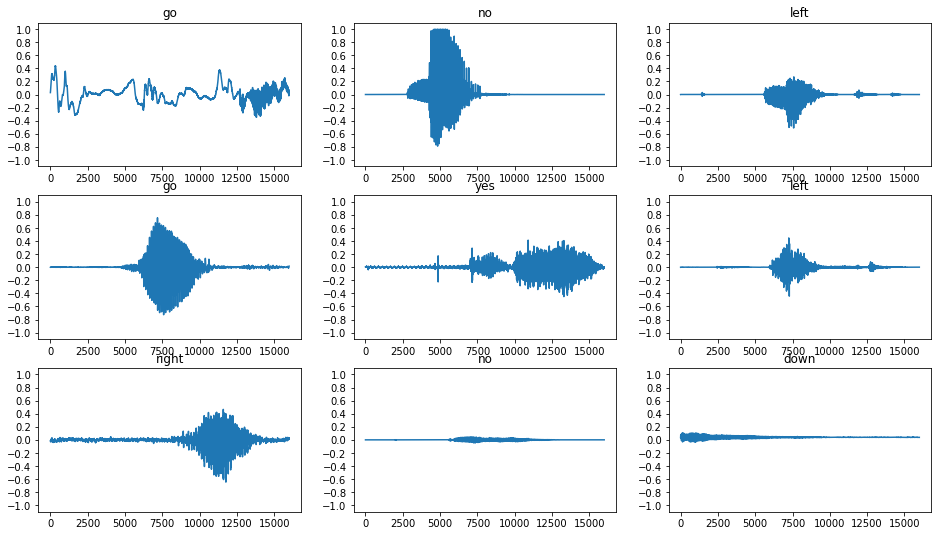

In [11]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

### Converting the waveform to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">this Coursera video</a> on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [12]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [13]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

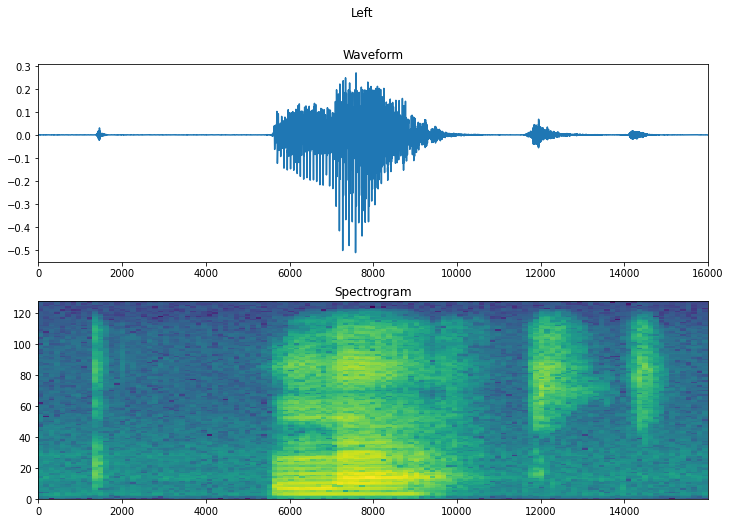

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [16]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Examine the spectrograms for different examples of the dataset:

In [18]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

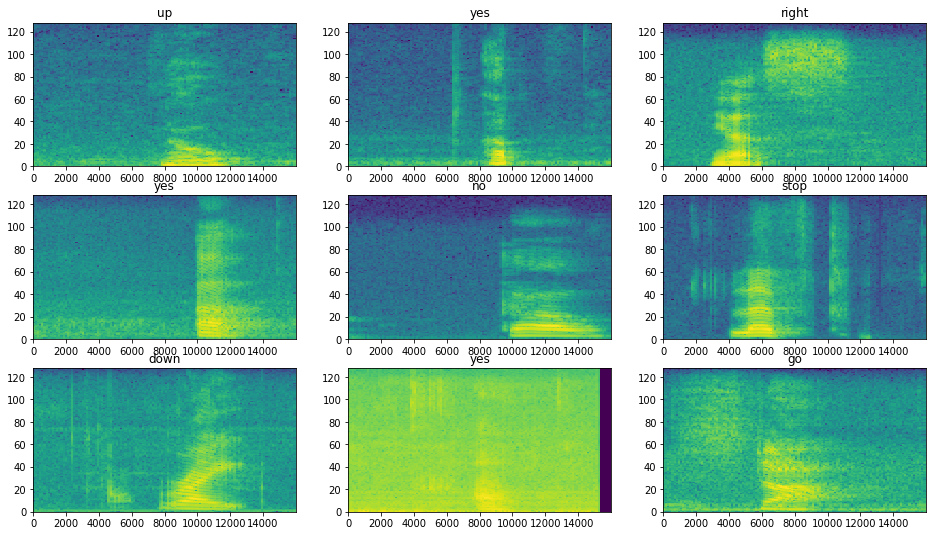

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

## Building the model 

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [20]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [21]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 128)      0         
 )                           

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Training the model

Train the model over 40 epochs :

In [23]:
!mkdir "checkpoint_model"

In [24]:
EPOCHS = 40

# Creating callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint_model/",
    save_weights_only=True,  monitor='val_accuracy', mode='max', save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/40
100/100 [==============================] - 71s 698ms/step - loss: 1.6768 - accuracy: 0.3889 - val_loss: 1.1706 - val_accuracy: 0.6146
Epoch 2/40
100/100 [==============================] - 74s 745ms/step - loss: 1.0595 - accuracy: 0.6111 - val_loss: 0.8124 - val_accuracy: 0.7344
Epoch 3/40
100/100 [==============================] - 68s 684ms/step - loss: 0.7792 - accuracy: 0.7152 - val_loss: 0.6783 - val_accuracy: 0.7839
Epoch 4/40
100/100 [==============================] - 72s 717ms/step - loss: 0.6228 - accuracy: 0.7717 - val_loss: 0.5947 - val_accuracy: 0.8216
Epoch 5/40
100/100 [==============================] - 68s 683ms/step - loss: 0.5255 - accuracy: 0.8131 - val_loss: 0.5240 - val_accuracy: 0.8359
Epoch 6/40
100/100 [==============================] - 71s 710ms/step - loss: 0.4388 - accuracy: 0.8441 - val_loss: 0.4518 - val_accuracy: 0.8607
Epoch 7/40
100/100 [==============================] - 68s 681ms/step - loss: 0.3729 - accuracy: 0.8628 - val_loss: 0.4008 - val_ac

In [25]:
# Loading the best model
model.load_weights("checkpoint_model/")

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

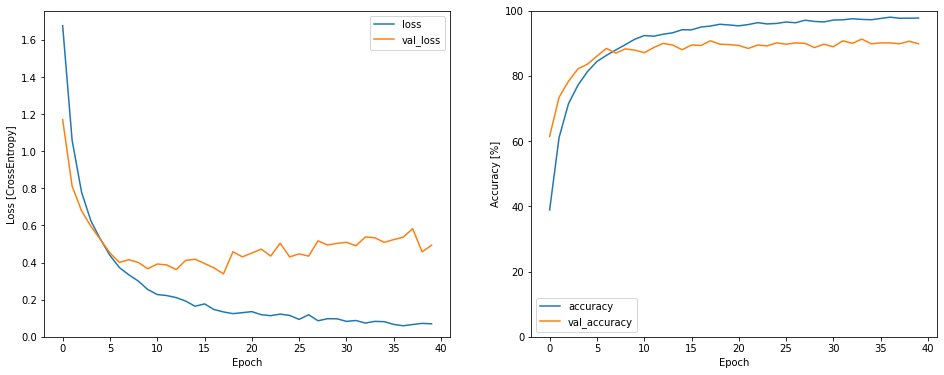

In [26]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluating the model performances 

Run the model on the test set and check the model's performance:

In [27]:
model_acc = model.evaluate(test_spectrogram_ds, return_dict=True)
model_acc

13/13 [==============================] - 4s 294ms/step - loss: 0.5210 - accuracy: 0.9026


{'loss': 0.5210460424423218, 'accuracy': 0.9026442170143127}

### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:

In [28]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 2s 172ms/step


In [29]:
y_pred = tf.argmax(y_pred, axis=1)

In [30]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

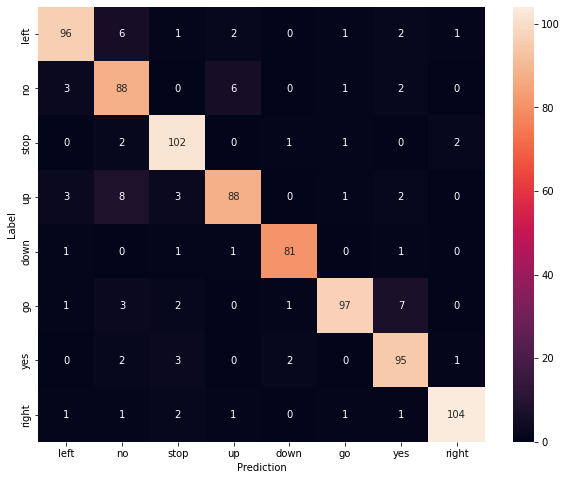

In [31]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

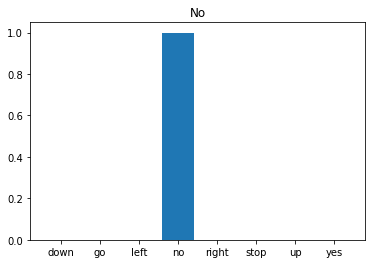

In [32]:
x = data_dir/'no/1bb6ed89_nohash_1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

In [33]:
# Saving the normal model
model.save('normal_model.h5')

## Quantisizing the model with differents optimizers (post training)

Now let's quantisize our model with TFLite to see if their size changed and their accuracy changed.

As the two ... optimizers are deprecated we won't be using them here.

To test our quantisized models, we will be using this function : 

In [34]:
# Defining a function to use the interpreter and compute his accuracy
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  results = np.array([])
  predictions = np.array([])
  for tests in list(test_spectrogram_ds) : 
    tests_predictions = []
    for indiv_test in tests[0] : 
      input = np.reshape(indiv_test, (1, 124, 129, 1))
      interpreter.set_tensor(input_index, input)
      # Run inference.
      interpreter.invoke()
      output = interpreter.tensor(output_index)
      tests_predictions.append(np.argmax(output()[0]))
    # Concatening arrays to have a final result on the accuracy
    results = np.concatenate((results, np.array(tests[len(tests)-1])), axis=0)
    predictions = np.concatenate((predictions, np.array(tests_predictions)), axis=0)
    
  # Compare prediction results with ground truth labels to calculate accuracy.
  accuracy = (predictions == results).mean()
  return accuracy

### Without optimization

In this part, we will convert our model into a TFLite model and check his size and performances.

In [35]:
# Creating our converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

# Save the model.
with open('model_no_opti.tflite', 'wb') as f:
  f.write(tflite_model)

tflite_size = os.path.getsize("model_no_opti.tflite")
print("Our lite model has a size of {0}, which means that each parameter has a size of {1}.".format(tflite_size, tflite_size / 2862731))

Our lite model has a size of 11454900, which means that each parameter has a size of 4.001388883552105.


And now, before doing some other quantisizing, we will check the normal model size

In [36]:
model_size = os.path.getsize("normal_model.h5")
print("Our lite model has a size of {0}, which means that each parameter has a size of {1}.".format(model_size, model_size / 2862731))

Our lite model has a size of 34407640, which means that each parameter has a size of 12.019166313565613.


As we can see, it is already 3 times smaller ! Now let's have a look on the performances (as a reminder our model as a 90% accuracy) :

In [37]:
# Preparing our lite model for the evaluation
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Evaluating the model
tflite_model_accuracy = evaluate_model(interpreter)

print('TFLite test_accuracy:', tflite_model_accuracy)
print('Model test accuracy:', model_acc.get("accuracy"))

TFLite test_accuracy: 0.9026442307692307
Model test accuracy: 0.9026442170143127


As we can see, the accuracy has barely changed even if we divided by 3 the size of the model !

### With the DEFAULT optimizer

In [38]:
# Creating our converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_default = converter.convert()

# Save the model.
with open('model_default.tflite', 'wb') as f:
  f.write(tflite_model_default)

tflite_size = os.path.getsize("model_default.tflite")
print("Our lite model with default optimization has a size of {0}, which means that each parameter has a size of {1}.".format(tflite_size, tflite_size / 2862731))

Our lite model with default optimization has a size of 2871104, which means that each parameter has a size of 1.0029248294722766.


As we can see, it is now 12 times smaller ! Now let's have a look on the performances (as a reminder our model as a 90% accuracy) :

In [39]:
# Preparing our lite model for the evaluation
interpreter = tf.lite.Interpreter(model_content=tflite_model_default)
interpreter.allocate_tensors()

# Evaluating the model
tflite_model_default_accuracy = evaluate_model(interpreter)

print('TFLite test_accuracy:', tflite_model_default_accuracy)
print('Model test accuracy:', model_acc.get("accuracy"))

TFLite test_accuracy: 0.8978365384615384
Model test accuracy: 0.9026442170143127


As we can see it here, its accuracy has dropped a little but we compressed the model to make it 12 time smaller.

### By using the EXPERIMENTAL_SPARSITY optimization

In [41]:
# Creating our converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.EXPERIMENTAL_SPARSITY]
tflite_model_experimental = converter.convert()

# Save the model.
with open('model_experimental.tflite', 'wb') as f:
  f.write(tflite_model_experimental)

tflite_size = os.path.getsize("model_experimental.tflite")
print("Our lite model with experimental optimization has a size of {0}, which means that each parameter has a size of {1}.".format(tflite_size, tflite_size / 2862731))

Our lite model with experimental optimization has a size of 11454900, which means that each parameter has a size of 4.001388883552105.


As we can see, it is similar to the classic quantization, with a size around 3 times smaller.

In [42]:
# Preparing our lite model for the evaluation
interpreter = tf.lite.Interpreter(model_content=tflite_model_experimental)
interpreter.allocate_tensors()

# Evaluating the model
tflite_model_experimental_accuracy = evaluate_model(interpreter)

print('TFLite test_accuracy:', tflite_model_experimental_accuracy)
print('Model test accuracy:', model_acc.get("accuracy"))

TFLite test_accuracy: 0.9026442307692307
Model test accuracy: 0.9026442170143127


Just like said before, the results did not changed a lot.

### By changing the type to FLOAT16

In [43]:
# Creating our converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model_float16 = converter.convert()

# Save the model.
with open('model_float16.tflite', 'wb') as f:
  f.write(tflite_model_float16)

tflite_size = os.path.getsize("model_float16.tflite")
print("Our lite model with float16 typing has a size of {0}, which means that each parameter has a size of {1}.".format(tflite_size, tflite_size / 2862731))

Our lite model with float16 typing has a size of 5730988, which means that each parameter has a size of 2.0019303245746807.


As we can see it, this is the second best compression with a lite model 6 times smaller.

In [45]:
# Preparing our lite model for the evaluation
interpreter = tf.lite.Interpreter(model_content=tflite_model_float16)
interpreter.allocate_tensors()

# Evaluating the model
tflite_model_float16_accuracy = evaluate_model(interpreter)

print('TFLite test_accuracy:', tflite_model_float16_accuracy)
print('Model test accuracy:', model_acc.get("accuracy"))

TFLite test_accuracy: 0.9026442307692307
Model test accuracy: 0.9026442170143127


As we can see it here, this is the best compression / accuracy quantization so far that we go here.

## Quantisizing aware training of the model with differents optimizers 

In this section we will have a look on the training with the quantisizing. The idea is to simulate the effects of the quantisizing during the training so that the model can ajust the weigth to take in account the quantization.

To do so, as the Resize and Normalization layers cannot be quantisized, we need to do it manually.


### Quantisizing the model 

In [55]:
quantize_model = tfmot.quantization.keras.quantize_model

# Function to define the layers to quantisize
def apply_quantization_to_layer(layer):
  if not isinstance(layer, tf.keras.layers.Resizing) and not isinstance(layer, tf.keras.layers.Normalization):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization_to_layer,
)

# q_aware stands for for quantization aware.
q_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

A l'aide de la fonction quantize de tensorflow_model_optimization, créer une seconde version de votre modèle entraîné nommé q_aware_model

In [56]:
# `quantize_model` requires a recompile.
q_aware_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 30, 30, 32)       387       
 erV2)                                                           
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 28, 28, 64)       18627     
 pperV2)                                                         
                                                                 
 quant_conv2d_2 (QuantizeWra  (None, 26, 26, 128)      74115     
 pperV2)                                                

We can here notice that our model is quantisized as we have QuantizeWrapperV2 layers.

### Training our quantisized aware model 

Let's now train our new model : 

In [57]:
history = q_aware_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=5,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/5
100/100 [==============================] - 98s 939ms/step - loss: 0.2844 - accuracy: 0.8945 - val_loss: 0.3523 - val_accuracy: 0.9010
Epoch 2/5
100/100 [==============================] - 79s 792ms/step - loss: 0.1113 - accuracy: 0.9602 - val_loss: 0.3917 - val_accuracy: 0.9010
Epoch 3/5
100/100 [==============================] - 84s 841ms/step - loss: 0.0830 - accuracy: 0.9720 - val_loss: 0.4305 - val_accuracy: 0.8997
Epoch 4/5
100/100 [==============================] - 80s 795ms/step - loss: 0.0786 - accuracy: 0.9737 - val_loss: 0.3978 - val_accuracy: 0.8997
Epoch 5/5
100/100 [==============================] - 80s 796ms/step - loss: 0.0760 - accuracy: 0.9731 - val_loss: 0.4615 - val_accuracy: 0.9062


In [60]:
# Loading the best model
q_aware_model.load_weights("checkpoint_model/")

Text(0, 0.5, 'Accuracy [%]')

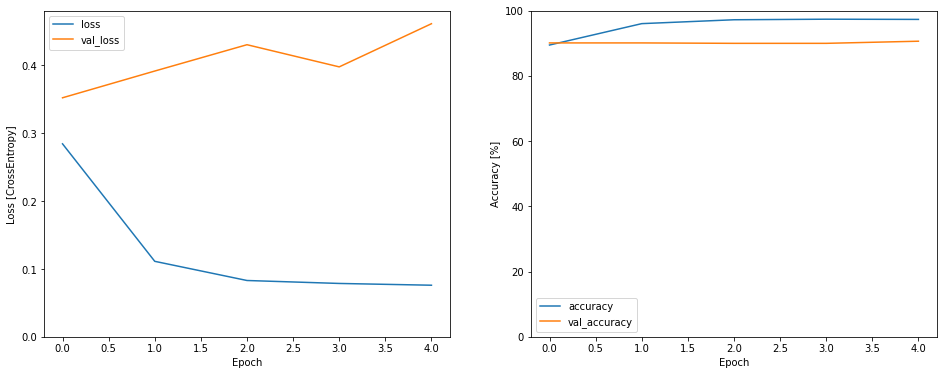

In [61]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluating our quantisized aware model 

Now let's evaluate the quantisized aware model : 

In [62]:
q_aware_model_acc = q_aware_model.evaluate(test_spectrogram_ds, return_dict=True)
q_aware_model_acc

13/13 [==============================] - 2s 181ms/step - loss: 0.4661 - accuracy: 0.9014


{'loss': 0.46613121032714844, 'accuracy': 0.901442289352417}

Now let's display it's confusion matrix 

In [64]:
y_pred = q_aware_model.predict(test_spectrogram_ds)

13/13 [==============================] - 2s 180ms/step


In [65]:
y_pred = tf.argmax(y_pred, axis=1)

In [66]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

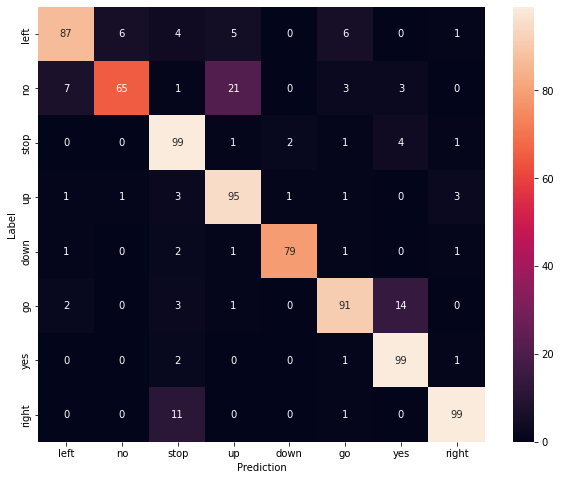

In [67]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Testing our model 

Here we are going to test our model to compare his results to the normal model 

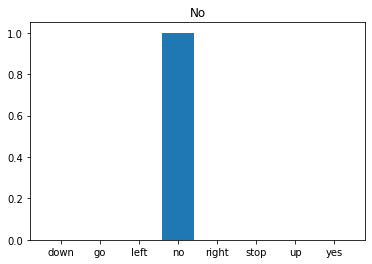

In [68]:
x = data_dir/'no/1bb6ed89_nohash_1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = q_aware_model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

And now finally we are going to save this model 

In [69]:
# Saving the normal model
q_aware_model.save('q_aware_model.h5')

### Without optimization

In this part, we will convert our model into a TFLite model and check his size and performances.

In [72]:
# Creating our converter
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)

tflite_q_aware_model = converter.convert()

# Save the model.
with open('q_aware_model_no_opti.tflite', 'wb') as f:
  f.write(tflite_q_aware_model)

tflite_size = os.path.getsize("q_aware_model_no_opti.tflite")
print("Our lite q aware model has a size of {0}, which means that each parameter has a size of {1}.".format(tflite_size, tflite_size / 2863202))

Our lite model has a size of 22919632, which means that each parameter has a size of 8.004895218709683.


As we can saw it below, our model is only 1.5 time smaller than the normal one :

In [73]:
model_size = os.path.getsize("q_aware_model.h5")
print("Our q aware model has a size of {0}, which means that each parameter has a size of {1}.".format(model_size, model_size / 2863202))

Our q aware model has a size of 34434304, which means that each parameter has a size of 12.02650179763775.


Let's compare the accuracy of the lite and normal model.

In [76]:
# Preparing our lite model for the evaluation
interpreter = tf.lite.Interpreter(model_content=tflite_q_aware_model)
interpreter.allocate_tensors()

# Evaluating the model
tflite_q_aware_model_accuracy = evaluate_model(interpreter)

print('TFLite test_accuracy:', tflite_q_aware_model_accuracy)
print('Model test accuracy:', q_aware_model_acc.get("accuracy"))

TFLite test_accuracy: 0.8497596153846154
Model test accuracy: 0.901442289352417


As we can see it here, the accuracy has been really impacted by the convertion to a lite model and the interpreter take way more time to do the predictions.

### With the DEFAULT optimizer

In [77]:
# Creating our converter
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_q_aware_model_default = converter.convert()

# Save the model.
with open('q_aware_model_default.tflite', 'wb') as f:
  f.write(tflite_q_aware_model_default)

tflite_size = os.path.getsize("q_aware_model_default.tflite")
print("Our lite q aware model with default optimization has a size of {0}, which means that each parameter has a size of {1}.".format(tflite_size, tflite_size / 2862731))

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Our lite q aware model with default optimization has a size of 2874856, which means that each parameter has a size of 1.0042354660636994.


As we can see, it is now 12 times smaller ! Now let's have a look on the performances (as a reminder our model as a 90% accuracy) :

In [82]:
# Preparing our lite model for the evaluation
interpreter = tf.lite.Interpreter(model_content=tflite_q_aware_model_default)
interpreter.allocate_tensors()

# Evaluating the model
tflite_q_aware_model_default_accuracy = evaluate_model(interpreter)

print('TFLite test_accuracy:', tflite_q_aware_model_default_accuracy)
print('Model test accuracy:', q_aware_model_acc.get("accuracy"))

TFLite test_accuracy: 0.859375
Model test accuracy: 0.901442289352417


As we can notice it, the accuracy is a little bit better than without the optimizer and the predictions were faster but we still have a 5% accuracy lost.

### By using the EXPERIMENTAL_SPARSITY optimization

In [79]:
# Creating our converter
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.EXPERIMENTAL_SPARSITY]
tflite_q_aware_model_experimental = converter.convert()

# Save the model.
with open('q_aware_model_experimental.tflite', 'wb') as f:
  f.write(tflite_q_aware_model_experimental)

tflite_size = os.path.getsize("q_aware_model_experimental.tflite")
print("Our lite q aware model with experimental optimization has a size of {0}, which means that each parameter has a size of {1}.".format(tflite_size, tflite_size / 2862731))

Our lite q aware model with experimental optimization has a size of 22919624, which means that each parameter has a size of 8.006209455236975.


Just like without the optimizers, the compression is about 1.5 our normal model size.

In [81]:
# Preparing our lite model for the evaluation
interpreter = tf.lite.Interpreter(model_content=tflite_q_aware_model_experimental)
interpreter.allocate_tensors()

# Evaluating the model
tflite_q_aware_model_experimental_accuracy = evaluate_model(interpreter)

print('TFLite test_accuracy:', tflite_q_aware_model_experimental_accuracy)
print('Model test accuracy:', q_aware_model_acc.get("accuracy"))

TFLite test_accuracy: 0.8497596153846154
Model test accuracy: 0.901442289352417


There is not much to say here as the results are really similar to the ones without any optimizers.

### By changing the type to FLOAT16

In [83]:
# Creating our converter
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_q_aware_model_float16 = converter.convert()

# Save the model.
with open('q_aware_model_float16.tflite', 'wb') as f:
  f.write(tflite_q_aware_model_float16)

tflite_size = os.path.getsize("q_aware_model_float16.tflite")
print("Our lite q aware model with float16 typing has a size of {0}, which means that each parameter has a size of {1}.".format(tflite_size, tflite_size / 2862731))

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Our lite q aware model with float16 typing has a size of 2874856, which means that each parameter has a size of 1.0042354660636994.


Unexpectedly, the compression is better than when using our normal model for this one but let's see the results.

In [84]:
# Preparing our lite model for the evaluation
interpreter = tf.lite.Interpreter(model_content=tflite_q_aware_model_float16)
interpreter.allocate_tensors()

# Evaluating the model
tflite_q_aware_model_float16_accuracy = evaluate_model(interpreter)

print('TFLite test_accuracy:', tflite_q_aware_model_float16_accuracy)
print('Model test accuracy:', model_acc.get("accuracy"))

TFLite test_accuracy: 0.859375
Model test accuracy: 0.9026442170143127


And finally, the results are quite the same with a 5% loss of accuracy here.

### To conclude about quantisized aware trained model

To conclude our tests on our q aware model, we can see that the results are not that goods. Indeed, the compression is most of the time less effective and the results have a 5% accuracy lost which is significative. So for our project, we will only used the post training quantisized models. 

## To download the models 

This section is here to download the model if wanted, by just running this code.

In [40]:
dl_file = False
try:
  from google.colab import files
except ImportError:
  pass
else:
  if (dl_file) : 
    files.download("/content/model_no_opti.tflite")